# A Robust Gaussian Kalman Filter
This notebook demonstrates the use of the robust Gaussian Kalman filter, as described in 
"**Robust Gaussian Kalman Filter with Outlier Detection**", by Wang et al., IEEE SPL, 2018.
I specifically consider a simple case where 
1. the state and measurements/observations are scalar,
2. the state is doing a random walk of the form 
$$
x[n] = x[n-1] + w[n], \text{ where } w[n] \sim \mathcal{N}(0,\sigma_{\text{state}}),
$$
3. we observe the noisy state or an outlier at each time instant, i.e., 
$$
y[n] = \begin{cases} 
&x[n] + v[n], \text{ with prob. } p_{\text{outlier}}, \text{ where } v[n] \sim \mathcal{N}(0,\sigma_{\text{obs}}),\\
&u[n], \text{ with prob. } 1 - p_{\text{outlier}}, \text{ where } u[n] \sim \text{Uniform[-T,T]}.
\end{cases}
$$

In [1]:
import numpy as np
from robust_gaussian import RobustGaussian
import matplotlib.pyplot as plt

%matplotlib inline

Let us first declare the constants used in defining the state and observation models.

In [2]:
state_noise_std = 0.1
observation_noise_std = 0.5
prob_outlier = 0.05
uniform_prob_bound = 10

Next, we implement a generator that produces a random walk.

In [3]:
def generate_random_walk(std=state_noise_std, num_samples=500, initial_point=1):
    x = initial_point
    for _ in range(num_samples):
        x = x + np.random.normal(0, std, 1)
        yield x

Below is the function that produces the observations. Note that it produces an outlier observation with probability `prob_outlier`.

In [4]:
def generate_observations(
    x,
    noise_std=observation_noise_std,
    outlier_probability=prob_outlier,
    uniform_prob_bound=uniform_prob_bound,
):
    """
    given the clean state, returns an observation, along with an outlier indicator
    """
    if np.random.uniform(low=0, high=1, size=1) < outlier_probability:
        return (
            np.random.uniform(low=-uniform_prob_bound, high=uniform_prob_bound, size=1),
            True,
        )
    return x + np.random.normal(0, noise_std, 1), False

We instantiate a robust Gaussian filter object. Pretending we don't have access to the true noise statistics, we slightly perturb them, when initializing the object.

In [5]:
filter = RobustGaussian(
    initial_mean=0.9,
    initial_variance=0.1,
    state_update_noise_variance=(state_noise_std**2) * 1.05,
    observation_noise_variance=(observation_noise_std**2) * 1.05,
)

We now generate the states, observations and run the filter. We save also the true outlier indicator and estimated outlier probability for each observation.

In [6]:
states = []
observations = []
filter_output = []

est_outlier_probability = []
outlier_indicator = []
for x in generate_random_walk(num_samples=500):
    observation, outlier = generate_observations(x)
    mean, var, prob = filter(observation)
    states.append(x)
    observations.append(observation)
    outlier_indicator.append(outlier)
    filter_output.append(mean)
    est_outlier_probability.append(prob)

Below is the output of the run. The filter output should ideally be close to the true state by successfully avoiding the outliers.

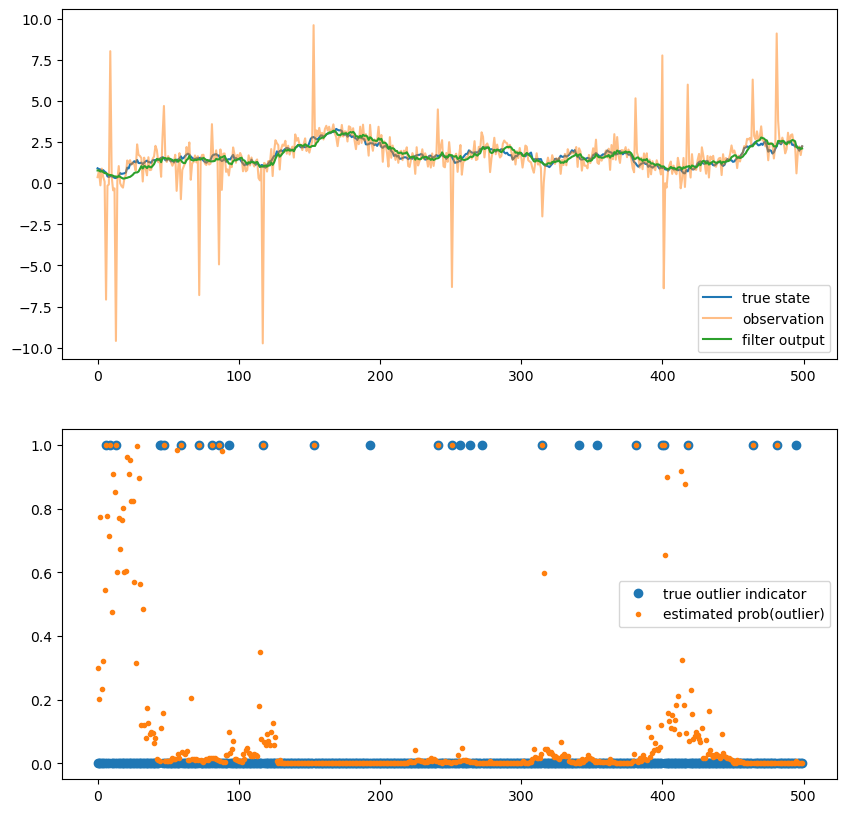

In [7]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2)
ax = axes[0]
ax.plot(states, label="true state")
ax.plot(observations, alpha=0.5, label="observation")
ax.plot(filter_output, label="filter output")
ax.legend()

ax = axes[1]
ax.plot(outlier_indicator, "o", label="true outlier indicator")
ax.plot(est_outlier_probability, ".", label="estimated prob(outlier)")
ax.legend()

*ibayram@ieee.org*, 2024